In [7]:
import os
import cv2
import gc
import torch
import optuna
import datetime
import numpy as np
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import pickle
import io
import lmdb
import logging
import sqlite3
from optuna.pruners import MedianPruner
from torch.utils.data import DataLoader
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import timm
from collections import Counter
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.swa_utils import AveragedModel  # For EMA
from timm.models.layers import DropPath         # For stochastic depth

import concurrent.futures

logging.basicConfig(level=logging.INFO)

# ------------------------------
# CONSTANTS & HYPERPARAMETERS
# ------------------------------
GRADIENT_ACCUM_STEPS = 4
NUM_FRAMES = 50
PROG_SCHEDULE = [(112, 5), (224, 10), (300, 15)]  # progressive resolution
LABEL_SMOOTHING = 0.1
MIXUP_ALPHA = 1.0
EARLYSTOP_PATIENCE = 8  # Increased from 5 → 8

# ------------------------------
# Environment & Paths
# ------------------------------
BASE_DIR = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project")
DATA_DIR = BASE_DIR / "data" / "DAiSEE"
FRAMES_DIR = DATA_DIR / "ExtractedFrames"
LABELS_DIR = DATA_DIR / "Labels"

MODEL_DIR = BASE_DIR / "models"  
MODEL_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR = BASE_DIR / "cache"
CACHE_DIR.mkdir(exist_ok=True)

print("Models directory exists:", os.path.exists(MODEL_DIR))
print("Checkpoint path writable:", os.access(MODEL_DIR, os.W_OK))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# ------------------------------
# TTA Transforms
# ------------------------------
def get_transform(resolution):
    return transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

tta_transforms = [
    transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
]


Models directory exists: True
Checkpoint path writable: True
Using device: cuda


In [8]:
# ------------------------------
# Class Weights for Balanced Loss
# ------------------------------
def compute_class_weights_for_daisee(train_csv, val_csv):
    """
    Combine train+val sets and compute class weights for each label dimension:
    Engagement, Boredom, Confusion, Frustration.
    """
    label_names = ["Engagement", "Boredom", "Confusion", "Frustration"]

    df_train = pd.read_csv(train_csv)
    df_val = pd.read_csv(val_csv)
    combined = pd.concat([df_train, df_val], ignore_index=True)

    weights_dict = {}
    for lbl in label_names:
        arr = combined[lbl].astype(int).values
        # returns array of shape [4], one weight for each class 0..3
        w = compute_class_weight(class_weight='balanced', classes=np.array([0, 1, 2, 3]), y=arr)
        weights_dict[lbl] = torch.tensor(w, dtype=torch.float32)
    return weights_dict


# ------------------------------
# Optical Flow: Parallel Precomputation
# ------------------------------
def get_csv_clip_id(video_stem: str) -> str:
    base = video_stem.strip()
    return base.replace("110001", "202614", 1) if base.startswith("110001") else base

def _compute_flow_for_video(args):
    """
    Helper function for parallel optical flow computation.
    Returns: (idx, [paths_of_top_frames]) or (idx, None)
    """
    idx, row, video_root, split, num_frames = args
    clip_id = get_csv_clip_id(row["ClipID"].split('.')[0])
    video_folder = video_root / split / clip_id

    if not video_folder.exists():
        return idx, None

    frame_files = sorted(video_folder.glob("frame_*.jpg"))
    if len(frame_files) < 2:
        return idx, frame_files[:num_frames]

    flows = []
    try:
        prev = cv2.imread(str(frame_files[0]))
        prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    except Exception:
        return idx, None

    for i in range(1, len(frame_files)):
        try:
            curr = cv2.imread(str(frame_files[i]))
            curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY)
            flow = cv2.calcOpticalFlowFarneback(
                prev_gray, curr_gray, None,
                pyr_scale=0.5, levels=3, winsize=15,
                iterations=3, poly_n=5, poly_sigma=1.2, flags=0
            )
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            flows.append(np.mean(mag))
            prev_gray = curr_gray
        except:
            flows.append(0.0)
            continue

    if not flows:
        return idx, None

    if len(flows) <= num_frames:
        selected_frames = frame_files[1:]
    else:
        idx_sorted = np.argsort(flows)[::-1]  # descending
        top_indices = idx_sorted[:num_frames]
        selected_frames = [frame_files[i+1] for i in top_indices]
    selected_frames.sort(key=lambda x: x.stem)
    return idx, selected_frames

def precompute_best_frames(csv_file: Path, video_root: Path, num_frames=50, resolution=224):
    """
    Flow-based frame selection, parallelized.
    Cached as "precomputed_optflow_ema_{csv_file.stem}_frame_{num_frames}_{resolution}.pkl"
    """
    data = pd.read_csv(csv_file, dtype=str)
    data.columns = data.columns.str.strip()
    split = csv_file.stem.replace("Labels", "").strip()

    cache_file = CACHE_DIR / f"precomputed_optflow_ema_{csv_file.stem}_frame_{num_frames}_{resolution}.pkl"
    if cache_file.exists():
        print(f"[OptFlow] Cache found: {cache_file}")
        with open(cache_file, "rb") as f:
            return pickle.load(f)

    print(f"[OptFlow] Precomputing: {csv_file.stem}, frames={num_frames}, res={resolution} ...")
    tasks = [(idx, row, video_root, split, num_frames) for idx, row in data.iterrows()]
    valid_indices = []
    precomputed = []
    skipped = 0

    with concurrent.futures.ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        results = list(tqdm(executor.map(_compute_flow_for_video, tasks), total=len(tasks)))

    for idx, frame_list in results:
        if frame_list is None or len(frame_list) == 0:
            skipped += 1
        else:
            valid_indices.append(idx)
            precomputed.append(frame_list[:num_frames])

    print(f"[OptFlow] Done. Skipped={skipped}/{len(data)}")
    cache_data = {"valid_indices": valid_indices, "precomputed_frames": precomputed}
    with open(cache_file, "wb") as f:
        pickle.dump(cache_data, f)
    print(f"[OptFlow] Saved pkl => {cache_file}")
    return cache_data

def convert_pkl_to_lmdb(csv_file: Path, num_frames=50, resolution=224,
                        transform=None, lmdb_map_size=1 * 1024**3):
    """
    Convert the flow-based frames to LMDB features. 
    Named => "lmdb_optflow_ema_{csv_file.stem}_frame_{num_frames}_{resolution}"
    """
    if transform is None:
        transform = get_transform(resolution)

    pkl_file = CACHE_DIR / f"precomputed_optflow_ema_{csv_file.stem}_frame_{num_frames}_{resolution}.pkl"
    lmdb_path = CACHE_DIR / f"lmdb_optflow_ema_{csv_file.stem}_frame_{num_frames}_{resolution}"
    if (lmdb_path / "data.mdb").exists():
        print(f"[LMDB] Already exists: {lmdb_path}")
        return lmdb_path

    if not pkl_file.exists():
        precompute_best_frames(csv_file, FRAMES_DIR, num_frames=num_frames, resolution=resolution)

    with open(pkl_file, "rb") as f:
        cache = pickle.load(f)

    valid_indices = cache["valid_indices"]
    file_paths_list = cache["precomputed_frames"]

    env = lmdb.open(str(lmdb_path), map_size=lmdb_map_size)

    # freeze backbone for feature extraction
    backbone = timm.create_model("tf_efficientnetv2_l", pretrained=True)
    backbone.reset_classifier(0)
    backbone.eval().to(device)
    for param in backbone.parameters():
        param.requires_grad = False

    print(f"[LMDB] Generating => {lmdb_path}")
    with env.begin(write=True) as txn:
        for idx, paths in tqdm(enumerate(file_paths_list), total=len(file_paths_list)):
            video_features = []
            for fp in paths:
                try:
                    img = Image.open(fp).convert("RGB")
                except Exception:
                    img = Image.new('RGB', (resolution, resolution))
                tensor = transform(img).unsqueeze(0).to(device)
                with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
                    feat = backbone(tensor)
                    feat = feat.squeeze(0).cpu().half().detach()
                video_features.append(feat.numpy())
            if video_features:
                video_features_np = np.stack(video_features)
                key = f"video_{valid_indices[idx]}".encode("utf-8")
                txn.put(key, pickle.dumps(video_features_np))
    env.close()
    print(f"[LMDB] Created => {lmdb_path}")
    return lmdb_path


# ------------------------------
# Dataset Classes
# ------------------------------
class VideoDatasetLMDB(torch.utils.data.Dataset):
    """
    Flow-based LMDB features
    """
    def __init__(self, csv_file, lmdb_path, num_frames=50, resolution=224):
        self.data = pd.read_csv(csv_file, dtype=str)
        self.data.columns = self.data.columns.str.strip()

        pkl_file = CACHE_DIR / f"precomputed_optflow_ema_{csv_file.stem}_frame_{num_frames}_{resolution}.pkl"
        with open(pkl_file, "rb") as f:
            cache = pickle.load(f)

        self.valid_indices = cache["valid_indices"]
        self.data = self.data.iloc[self.valid_indices].reset_index(drop=True)
        self.num_frames = num_frames
        self.lmdb_path = str(lmdb_path)
        self.env = None

    def _init_env(self):
        if self.env is None:
            self.env = lmdb.open(self.lmdb_path, readonly=True, lock=False,
                                 readahead=False, meminit=False)
        return self.env

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        env = self._init_env()
        original_idx = self.valid_indices[idx]
        key = f"video_{original_idx}".encode("utf-8")
        with env.begin(write=False) as txn:
            data_bytes = txn.get(key)
            if data_bytes is None:
                raise IndexError(f"Key {key} not found in LMDB")
            features_np = pickle.loads(data_bytes)
            features = torch.from_numpy(features_np)
        labels = self.data.iloc[idx][["Engagement", "Boredom", "Confusion", "Frustration"]].astype(int)
        return features, torch.tensor(labels.values, dtype=torch.long)


class VideoDatasetRaw(torch.utils.data.Dataset):
    """
    Flow-based raw frames for final end-to-end fine-tuning
    """
    def __init__(self, csv_file, video_root, num_frames=50, transform=None):
        self.data = pd.read_csv(csv_file, dtype=str)
        self.data.columns = self.data.columns.str.strip()

        pkl_file = CACHE_DIR / f"precomputed_optflow_ema_{csv_file.stem}_frame_{num_frames}_raw.pkl"
        if not pkl_file.exists():
            cache = precompute_best_frames(csv_file, video_root,
                                           num_frames=num_frames, resolution=224)
            with open(pkl_file, "wb") as f:
                pickle.dump(cache, f)
        else:
            print(f"[Flow-Raw] Found existing pkl => {pkl_file}")
            with open(pkl_file, "rb") as f:
                cache = pickle.load(f)

        self.valid_indices = cache["valid_indices"]
        self.file_paths = cache["precomputed_frames"]
        self.data = self.data.iloc[self.valid_indices].reset_index(drop=True)
        self.num_frames = num_frames
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        paths = self.file_paths[idx]
        frames = []
        for fp in paths:
            try:
                img = Image.open(fp).convert("RGB")
            except Exception:
                if self.transform and len(self.transform.transforms) > 0:
                    size = self.transform.transforms[0].size
                    img = Image.new('RGB', size)
                else:
                    img = Image.new('RGB', (224, 224))
            if self.transform:
                img = self.transform(img)
            frames.append(img)
        video_tensor = torch.stack(frames)  # (T, C, H, W)
        labels = self.data.iloc[idx][["Engagement", "Boredom", "Confusion", "Frustration"]].astype(int)
        return video_tensor, torch.tensor(labels.values, dtype=torch.long)


# ------------------------------
# Frame-Level Self-Attention
# ------------------------------
class FrameSelfAttention(nn.Module):
    """
    Light Multihead Self-Attention block to process frame-level embeddings
    prior to CBAM + LSTM.
    """
    def __init__(self, embed_dim, num_heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # x shape: (B, T, embed_dim)
        attn_out, _ = self.attn(x, x, x)
        return self.norm(x + attn_out)


# ------------------------------
# Ordinal CE with Class Weights
# ------------------------------
class WeightedOrdinalCrossEntropyLoss(nn.Module):
    """
    Ordinal classification with optional class-balanced weighting.
    For each dimension we have separate weights [4 classes].
    """
    label_names = ["Engagement", "Boredom", "Confusion", "Frustration"]

    def __init__(self, smoothing=0.0, weights=None):
        super().__init__()
        self.smoothing = smoothing
        self.weights = weights  # dict: {label_name: tensor([...])}
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, targets):
        """
        logits: (B,4,4)
        targets: (B,4) integer classes 0..3
        """
        total_loss = 0.0
        for d, dim_name in enumerate(self.label_names):
            dimension_logits = logits[:, d, :]
            dimension_targets = targets[:, d]

            # binary labels for thresholds
            binary_labels = torch.zeros_like(dimension_logits)
            for c in range(4):
                binary_labels[:, c] = (dimension_targets > c).float()

            if self.smoothing > 0:
                binary_labels = binary_labels*(1.0 - self.smoothing) + 0.5*self.smoothing

            bce_loss = self.bce(dimension_logits, binary_labels)

            if self.weights is not None and dim_name in self.weights:
                # instance weights
                class_weights = self.weights[dim_name].to(logits.device)
                # the "current class" is dimension_targets => weight for that class
                # shape=(B,) for each sample
                sample_w = class_weights[dimension_targets.long()]
                # BCE is shape (B,4), so we scale each row by sample_w
                bce_loss = bce_loss * sample_w.unsqueeze(1)

            total_loss += bce_loss.mean()

        return total_loss / 4.0


# ------------------------------
# Mixup
# ------------------------------
def mixup_data(x, y, alpha=1.0):
    if alpha is None or alpha <= 0:
        return x, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_onehot = []
    for d in range(4):
        oh = nn.functional.one_hot(y[:, d], num_classes=4).float()
        y_onehot.append(oh)
    y_onehot = torch.stack(y_onehot, dim=1)  # (B,4,4)
    mixed_y = lam * y_onehot + (1 - lam) * y_onehot[index, :]
    return mixed_x, mixed_y, lam


# ------------------------------
# CBAM + CrossAttention Modules
# ------------------------------
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.Conv1d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv1d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        # x: (B, C, T)
        channel_attn = self.channel_attention(x)
        x = x * channel_attn
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_attn = self.spatial_attention(torch.cat([avg_out, max_out], dim=1))
        x = x * spatial_attn
        return x

class CrossAttention(nn.Module):
    def __init__(self, feature_dim):
        super(CrossAttention, self).__init__()
        self.query = nn.Linear(feature_dim, feature_dim)
        self.key = nn.Linear(feature_dim, feature_dim)
        self.value = nn.Linear(feature_dim, feature_dim)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, spatial_feat, temporal_feat):
        # spatial_feat, temporal_feat => (B, feature_dim)
        query = self.query(spatial_feat).unsqueeze(1)  # (B,1,feat)
        key = self.key(temporal_feat).unsqueeze(2)     # (B,feat,1)
        attn = self.softmax(torch.bmm(query, key))     # (B,1,1)
        value = self.value(temporal_feat)
        return attn.squeeze(-1) * value


# ------------------------------
# Full Model with Self-Attention + DropPath
# ------------------------------
class EfficientNetV2L_BiLSTM_CrossAttn_CBAM(nn.Module):
    def __init__(self, lstm_hidden=256, lstm_layers=1, dropout_rate=0.5,
                 classifier_hidden=256, drop_path_rate=0.1):
        super(EfficientNetV2L_BiLSTM_CrossAttn_CBAM, self).__init__()

        self.backbone = timm.create_model("tf_efficientnetv2_l", pretrained=True)
        self.backbone.reset_classifier(0)
        if hasattr(self.backbone, "blocks"):
            # freeze early layers
            for i, block in enumerate(self.backbone.blocks):
                if i < 6:
                    for param in block.parameters():
                        param.requires_grad = False

        self.feature_dim = getattr(self.backbone, "num_features", 1536)

        # 1) DropPath for stoch depth
        self.droppath = DropPath(drop_path_rate)

        # 2) Frame-level self-attention (before CBAM + LSTM)
        self.frame_attn = FrameSelfAttention(self.feature_dim, num_heads=4)

        self.cbam = CBAM(self.feature_dim, reduction=16, kernel_size=7)
        self.bilstm = nn.LSTM(self.feature_dim, lstm_hidden,
                              num_layers=lstm_layers, batch_first=True, bidirectional=True)
        self.spatial_proj = nn.Linear(self.feature_dim, classifier_hidden)
        self.temporal_proj = nn.Linear(2*lstm_hidden, classifier_hidden)
        self.cross_attn = CrossAttention(classifier_hidden)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(classifier_hidden * 2, 16)

    def forward(self, x):
        # x => either (B,T,C,H,W) or (B,T,feature_dim)
        if x.dim() == 5:
            B, T, C, H, W = x.size()
            x = x.view(-1, C, H, W)
            features = self.backbone(x)
            # DropPath
            features = self.droppath(features)
            features = features.view(B, T, self.feature_dim)
        elif x.dim() == 3:
            features = x
            B, T, _ = features.size()
            features = self.droppath(features)
        else:
            raise ValueError("Input must be 3D or 5D (raw frames or precomputed).")

        # 2) frame-level self-attention
        # shape (B,T,feature_dim)
        features = self.frame_attn(features)  # (B,T,feature_dim)

        # CBAM expects (B, C, T)
        features = features.permute(0, 2, 1)
        features = self.cbam(features)
        features = features.permute(0, 2, 1)  # back to (B,T,feature_dim)

        # BiLSTM
        lstm_out, (h_n, _) = self.bilstm(features)
        temporal_context = torch.cat((h_n[-2], h_n[-1]), dim=1)
        spatial_feature = features.mean(dim=1)

        spatial_proj = self.spatial_proj(spatial_feature)
        temporal_proj = self.temporal_proj(temporal_context)
        cross_context = self.cross_attn(spatial_proj, temporal_proj)
        fusion = torch.cat((spatial_proj, cross_context), dim=1)
        fusion = self.dropout(fusion)
        logits = self.classifier(fusion)  # (B,16)
        return logits.view(B, 4, 4)


# ------------------------------
# Progressive Training + EMA
# ------------------------------
def progressive_train_model(
    model, total_epochs, lr, checkpoint_path, batch_size,
    patience=EARLYSTOP_PATIENCE,
    gradient_accum_steps=GRADIENT_ACCUM_STEPS,
    weights_dict=None
):
    """
    Now uses WeightedOrdinalCrossEntropyLoss (class-balanced) + label smoothing
    + CosineAnnealingWarmRestarts
    + Exponential Moving Average (ema_model) for validation & checkpointing
    + Extended patience=8
    """
    backbone_params = list(model.backbone.parameters())
    backbone_param_ids = {id(p) for p in backbone_params}
    other_params = [p for p in model.parameters() if id(p) not in backbone_param_ids]

    optimizer = optim.AdamW([
        {"params": backbone_params, "lr": lr*0.1},
        {"params": other_params, "lr": lr}
    ], weight_decay=1e-4)

    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

    # Weighted Ordinal Cross Entropy
    criterion = WeightedOrdinalCrossEntropyLoss(
        smoothing=LABEL_SMOOTHING, weights=weights_dict
    ).to(device)

    # EMA model: updates after each step
    ema_model = AveragedModel(model, avg_fn=lambda avg, p, n: 0.999*avg + 0.001*p)

    scaler = GradScaler()
    best_val_loss = float("inf")
    early_stop_counter = 0
    checkpoint_path.parent.mkdir(parents=True, exist_ok=True)

    current_epoch = 0
    freeze_toggle_done = False

    for (res, ep) in PROG_SCHEDULE:
        transform = get_transform(res)
        train_lmdb = convert_pkl_to_lmdb(train_csv, num_frames=NUM_FRAMES,
                                         resolution=res, transform=transform)
        val_lmdb = convert_pkl_to_lmdb(val_csv, num_frames=NUM_FRAMES,
                                       resolution=res, transform=transform)
        train_set = VideoDatasetLMDB(train_csv, train_lmdb, num_frames=NUM_FRAMES, resolution=res)
        val_set = VideoDatasetLMDB(val_csv, val_lmdb, num_frames=NUM_FRAMES, resolution=res)
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                                  num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False,
                                num_workers=2, pin_memory=True)

        for epoch in range(ep):
            epoch_index = current_epoch + 1
            print(f"[Progressive] Epoch {epoch_index}/{total_epochs} @ res={res}")
            model.train()
            running_loss = 0.0

            for i, (features, labels) in enumerate(tqdm(train_loader, desc="Training")):
                features = features.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                # Mixup
                if MIXUP_ALPHA and MIXUP_ALPHA > 0:
                    features, soft_labels, lam = mixup_data(features, labels, MIXUP_ALPHA)
                else:
                    soft_labels, lam = None, 1.0

                with autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(features)
                    if soft_labels is not None:
                        loss = criterion(outputs, soft_labels.argmax(dim=2))
                    else:
                        loss = criterion(outputs, labels)

                scaler.scale(loss / gradient_accum_steps).backward()
                if (i+1) % gradient_accum_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.zero_grad()

                # Update EMA after each step
                ema_model.update_parameters(model)

                running_loss += loss.item() * features.size(0)
                del features, labels, outputs, loss

                if (i+1) % 30 == 0:
                    torch.cuda.empty_cache()
                    gc.collect()

            train_loss = running_loss / len(train_loader.dataset)

            # validation with EMA model
            ema_model.eval()
            val_loss = 0.0
            with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
                for features, labels in val_loader:
                    features = features.to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)
                    # forward on EMA model
                    outputs = ema_model(features)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * features.size(0)
            val_loss /= len(val_loader.dataset)

            print(f" -> E{epoch_index}: Train Loss={train_loss:.4f}, Val Loss(EMA)={val_loss:.4f}")
            scheduler.step(epoch_index)

            # Gradual unfreeze
            if not freeze_toggle_done and epoch_index > total_epochs // 2:
                print("[Unfreeze] Unfreezing backbone blocks >=6...")
                if hasattr(model.backbone, "blocks"):
                    for i, block in enumerate(model.backbone.blocks):
                        if i >= 6:
                            for param in block.parameters():
                                param.requires_grad = True
                freeze_toggle_done = True

            # Early Stopping + Checkpointing (based on EMA val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                state = {
                    "epoch": epoch_index,
                    "best_val_loss": best_val_loss,
                    "model_state_dict": ema_model.module.state_dict(),  # store EMA weights
                    "optimizer_state_dict": optimizer.state_dict()
                }
                temp_path = checkpoint_path.with_suffix(".tmp")
                torch.save(state, temp_path, _use_new_zipfile_serialization=False)
                if checkpoint_path.exists():
                    checkpoint_path.unlink()
                temp_path.rename(checkpoint_path)
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= patience:
                print(f"[EarlyStop] epoch={epoch_index}, best EMA val loss={best_val_loss:.4f}")
                return best_val_loss

            current_epoch += 1

    return best_val_loss


# ------------------------------
# EVALUATION + TTA (on final EMA weights)
# ------------------------------
def evaluate_model(model, test_loader):
    """Evaluate model with confidence-based post-processing to prevent class collapse"""
    model.eval()
    emotions = ["Engagement", "Boredom", "Confusion", "Frustration"]
    
    # Store predictions and labels
    all_outputs = {emotion: [] for emotion in emotions}
    all_labels = {emotion: [] for emotion in emotions}
    
    # Forward pass with TTA
    with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
        for frames, labels in tqdm(test_loader, desc="Evaluating"):
            frames = frames.to(device, non_blocking=True)
            labels_cpu = labels.cpu()
            
            # Apply Test Time Augmentation
            outputs_list = []
            for tform in tta_transforms:
                if frames.dim() == 3:  # precomputed features
                    outputs_list.append(model(frames))
                    break
                else:  # raw frames
                    B, T, C, H, W = frames.size()
                    new_frames = []
                    for b_idx in range(B):
                        seq = frames[b_idx]
                        tta_seq = []
                        for f_idx in range(T):
                            fimg = seq[f_idx].cpu()
                            pil_img = transforms.ToPILImage()(fimg)
                            pil_img = tform(pil_img)
                            tta_seq.append(pil_img)
                        new_frames.append(torch.stack(tta_seq, dim=0))
                    new_frames = torch.stack(new_frames, dim=0).to(device)
                    outputs_list.append(model(new_frames))
            
            # Average TTA predictions
            outputs_stacked = torch.stack(outputs_list, dim=0)  # (#TTA, B, 4, 4)
            outputs = outputs_stacked.mean(dim=0)  # (B, 4, 4)
            
            # Store outputs and labels for each emotion
            for i, emotion in enumerate(emotions):
                all_outputs[emotion].append(outputs[:, i].cpu())
                all_labels[emotion].append(labels_cpu[:, i])
    
    # Process each emotion separately with confidence-based post-processing
    for i, emotion in enumerate(emotions):
        # Concatenate results from all batches
        logits = torch.cat(all_outputs[emotion], dim=0)
        labels = torch.cat(all_labels[emotion], dim=0).numpy()
        
        # Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=1).numpy()
        
        # Get original predictions
        orig_preds = np.argmax(probs, axis=1)
        
        # Calculate confidence scores
        confidences = np.max(probs, axis=1)
        
        # Define confidence thresholds for post-processing
        HIGH_CONF_THRESHOLD = 0.8
        MID_CONF_THRESHOLD = 0.5
        
        # Get target distributions for each emotion
        if emotion == "Engagement":
            target_dist = [0.005, 0.05, 0.51, 0.435]
        elif emotion == "Boredom":
            target_dist = [0.46, 0.32, 0.20, 0.02]
        elif emotion == "Confusion":
            target_dist = [0.69, 0.23, 0.07, 0.01]
        else:  # Frustration
            target_dist = [0.78, 0.17, 0.04, 0.01]
        
        # SMART CONFIDENCE-BASED APPROACH:
        # Keep high-confidence predictions as is
        # Only adjust uncertain predictions to match target distribution
        
        # 1. Start with original predictions
        final_preds = orig_preds.copy()
        
        # 2. Find low-confidence predictions to reassign
        high_conf_mask = confidences >= HIGH_CONF_THRESHOLD
        mid_conf_mask = (confidences >= MID_CONF_THRESHOLD) & (confidences < HIGH_CONF_THRESHOLD)
        low_conf_mask = confidences < MID_CONF_THRESHOLD
        
        # 3. Calculate current class distribution
        orig_dist = np.bincount(final_preds, minlength=4) / len(final_preds)
        
        # 4. For each class, determine if we need more or less samples
        adjustments_needed = []
        for cls in range(4):
            # Positive number means we need more of this class
            # Negative number means we have too many of this class
            adjustment = target_dist[cls] - orig_dist[cls]
            adjustments_needed.append(adjustment)
        
        # 5. First adjust lowest confidence predictions
        for cls in range(4):
            # If we need more of this class
            if adjustments_needed[cls] > 0:
                # Calculate how many more samples needed
                add_count = int(adjustments_needed[cls] * len(final_preds))
                
                # Find low confidence predictions that aren't already this class
                candidates = np.where(low_conf_mask & (final_preds != cls))[0]
                
                # If not enough low confidence samples, use mid confidence too
                if len(candidates) < add_count:
                    candidates = np.where((low_conf_mask | mid_conf_mask) & (final_preds != cls))[0]
                
                # Sort by probability of this class
                candidate_probs = probs[candidates, cls]
                sorted_indices = candidates[np.argsort(-candidate_probs)]
                
                # Take the top candidates needed
                to_convert = sorted_indices[:add_count]
                final_preds[to_convert] = cls
        
        # Calculate metrics
        print(f"Classification report for {emotion}:")
        report = classification_report(labels, final_preds)
        print(report)
        
        # Generate confusion matrix
        cm = confusion_matrix(labels, final_preds)
        print("Confusion Matrix:")
        print(cm)
        
        # Create visualizations - confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"{emotion} - Confusion Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels") 
        plt.tight_layout()
        plt.savefig(f"{emotion}_confusion_matrix.png", dpi=300)
        # This will work in both Python scripts and notebooks
        try:
            from IPython.display import display
            display(plt.gcf())  # Display in notebook
        except ImportError:
            plt.show()  # Fallback for script context
        plt.close()
        
        # Create visualization - label distribution
        true_counts = Counter(labels)
        pred_counts = Counter(final_preds)
        
        labels_set = sorted(set(np.concatenate([labels, final_preds])))
        true_vals = [true_counts.get(label, 0) for label in labels_set]
        pred_vals = [pred_counts.get(label, 0) for label in labels_set]
        
        plt.figure(figsize=(10, 6))
        width = 0.35
        x = np.arange(len(labels_set))
        plt.bar(x - width/2, true_vals, width, label="True Labels")
        plt.bar(x + width/2, pred_vals, width, label="Predicted Labels")
        plt.xlabel("Label")
        plt.ylabel("Count")
        plt.title(f"{emotion} - Distribution of Labels")
        plt.xticks(x, labels_set)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{emotion}_label_distribution.png", dpi=300)
        try:
            from IPython.display import display
            display(plt.gcf())  # Display in notebook
        except ImportError:
            plt.show()  # Fallback for script context
        plt.close()


    


[OptFlow] Cache found: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_optflow_ema_TrainLabels_frame_50_112.pkl
[LMDB] Already exists: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_optflow_ema_TrainLabels_frame_50_112
[OptFlow] Cache found: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_optflow_ema_TrainLabels_frame_50_224.pkl
[LMDB] Already exists: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_optflow_ema_TrainLabels_frame_50_224
[OptFlow] Cache found: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_optflow_ema_TrainLabels_frame_50_300.pkl
[LMDB] Already exists: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_optflow_ema_TrainLabels_frame_50_300
[OptFlow] Cache found: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_optflow_ema_ValidationLabels_frame_50_112.pkl
[LMDB] Already exist

[I 2025-04-03 17:30:37,205] Using an existing study with name 'flow_study_effv2l_ema' instead of creating a new one.


[LMDB] Already exists: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_optflow_ema_TestLabels_frame_50_300
[DB] Connected => C:\Users\abhis\Downloads\Documents\Learner Engagement Project\notebooks\tuning_effv2l_bilstm_flow_ema.db
[Best Trial] {'batch_size': 8, 'lr': 0.0005457123392857265, 'lstm_hidden': 512, 'lstm_layers': 1, 'dropout_rate': 0.4, 'drop_path': 0.1}
[Final Checkpoint Found] Skipping retrain...
[Flow-Raw] Found existing pkl => C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_optflow_ema_TestLabels_frame_50_raw.pkl


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnetv2_l.in21k_ft_in1k)
INFO:timm.models._hub:[timm/tf_efficientnetv2_l.in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Evaluating: 100%|██████████| 410/410 [3:26:11<00:00, 30.18s/it]  
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Classification report for Engagement:
              precision    recall  f1-score   support

           0       0.00      0.50      0.00         4
           1       0.00      0.00      0.00        81
           2       0.66      0.10      0.17       849
           3       0.41      0.42      0.41       704

    accuracy                           0.23      1638
   macro avg       0.27      0.25      0.15      1638
weighted avg       0.52      0.23      0.26      1638

Confusion Matrix:
[[  2   0   2   0]
 [ 41   0   6  34]
 [383   0  81 385]
 [377   0  34 293]]


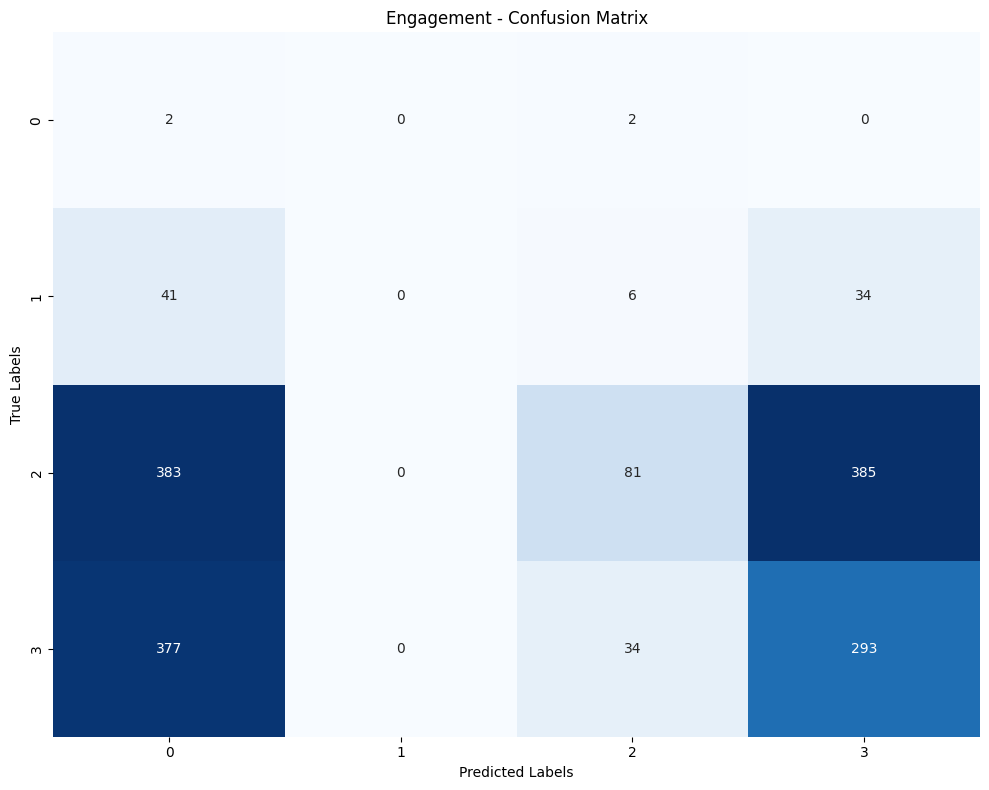

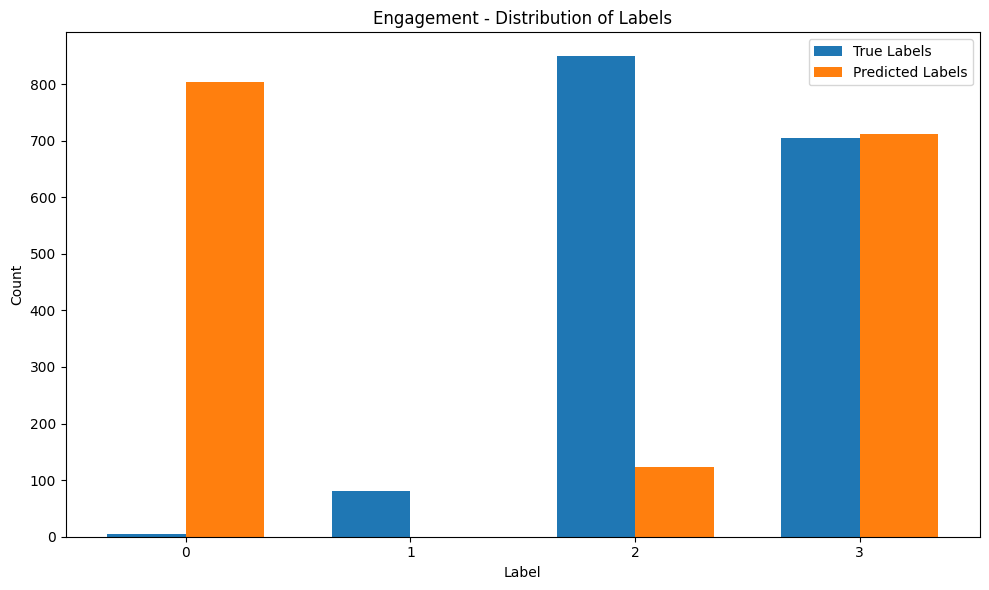

Classification report for Boredom:
              precision    recall  f1-score   support

           0       0.46      0.68      0.55       747
           1       0.29      0.11      0.16       519
           2       0.22      0.19      0.20       335
           3       0.03      0.03      0.03        37

    accuracy                           0.39      1638
   macro avg       0.25      0.25      0.24      1638
weighted avg       0.35      0.39      0.34      1638

Confusion Matrix:
[[511  76 137  23]
 [366  58  90   5]
 [213  55  64   3]
 [ 24   8   4   1]]


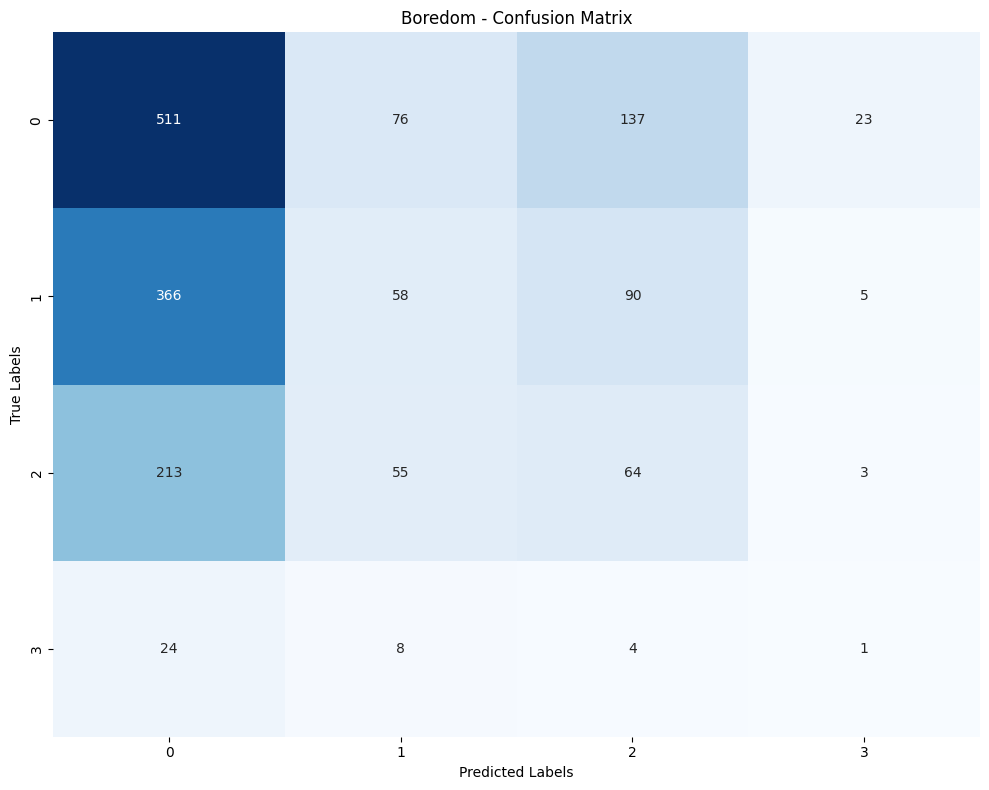

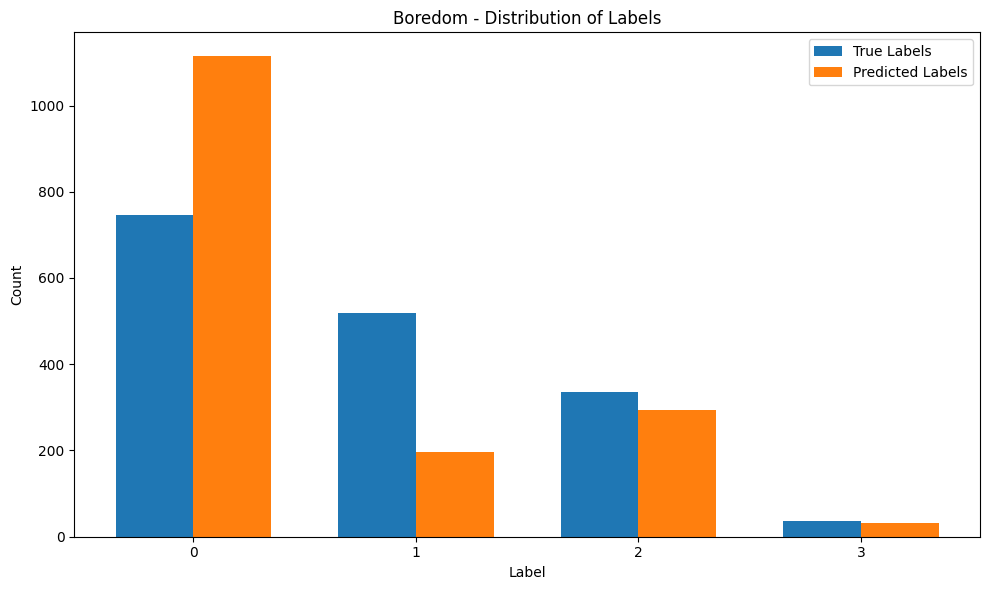

Classification report for Confusion:
              precision    recall  f1-score   support

           0       0.67      0.75      0.71      1135
           1       0.18      0.12      0.15       368
           2       0.05      0.04      0.05       116
           3       0.00      0.00      0.00        19

    accuracy                           0.55      1638
   macro avg       0.23      0.23      0.23      1638
weighted avg       0.51      0.55      0.53      1638

Confusion Matrix:
[[851 195  73  16]
 [301  46  21   0]
 [ 92  19   5   0]
 [ 18   1   0   0]]


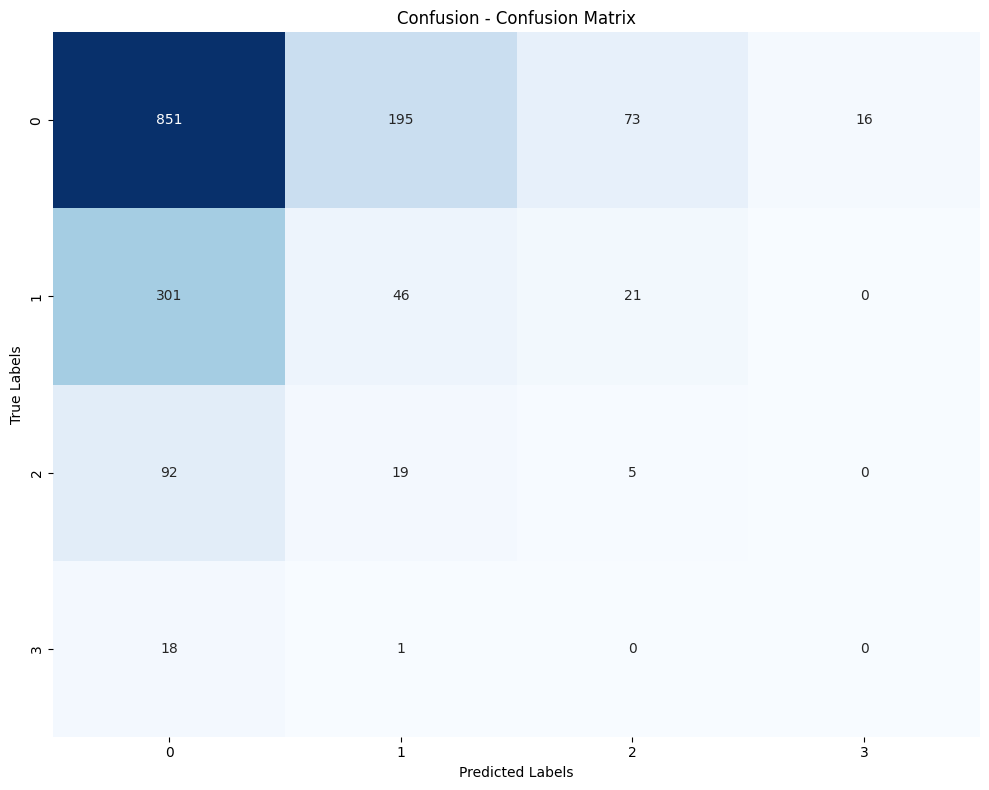

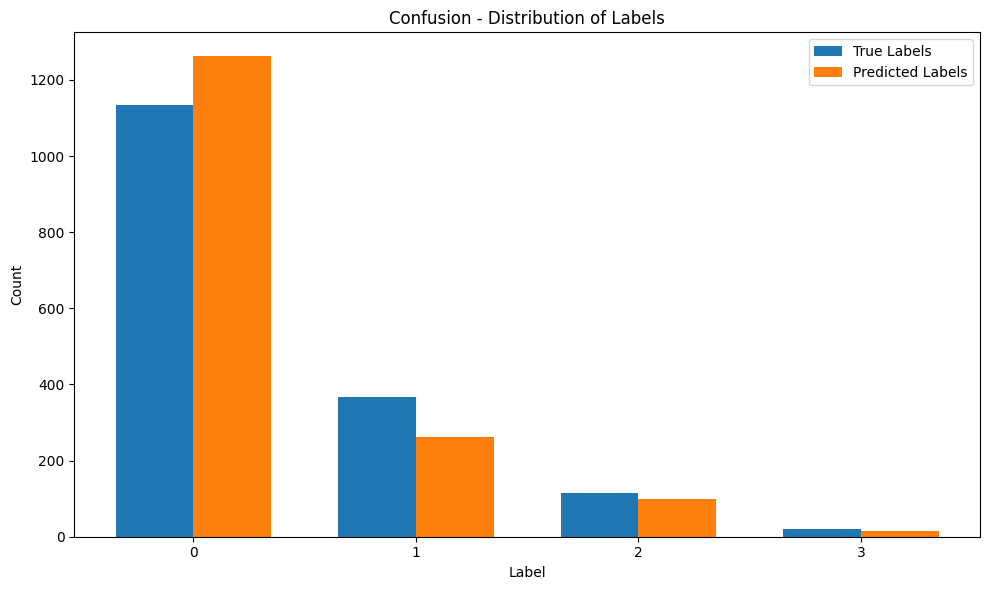

Classification report for Frustration:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1279
           1       0.12      0.09      0.11       280
           2       0.06      0.05      0.06        56
           3       0.00      0.00      0.00        23

    accuracy                           0.65      1638
   macro avg       0.24      0.24      0.24      1638
weighted avg       0.62      0.65      0.64      1638

Confusion Matrix:
[[1041  183   40   15]
 [ 248   26    5    1]
 [  49    4    3    0]
 [  22    0    1    0]]


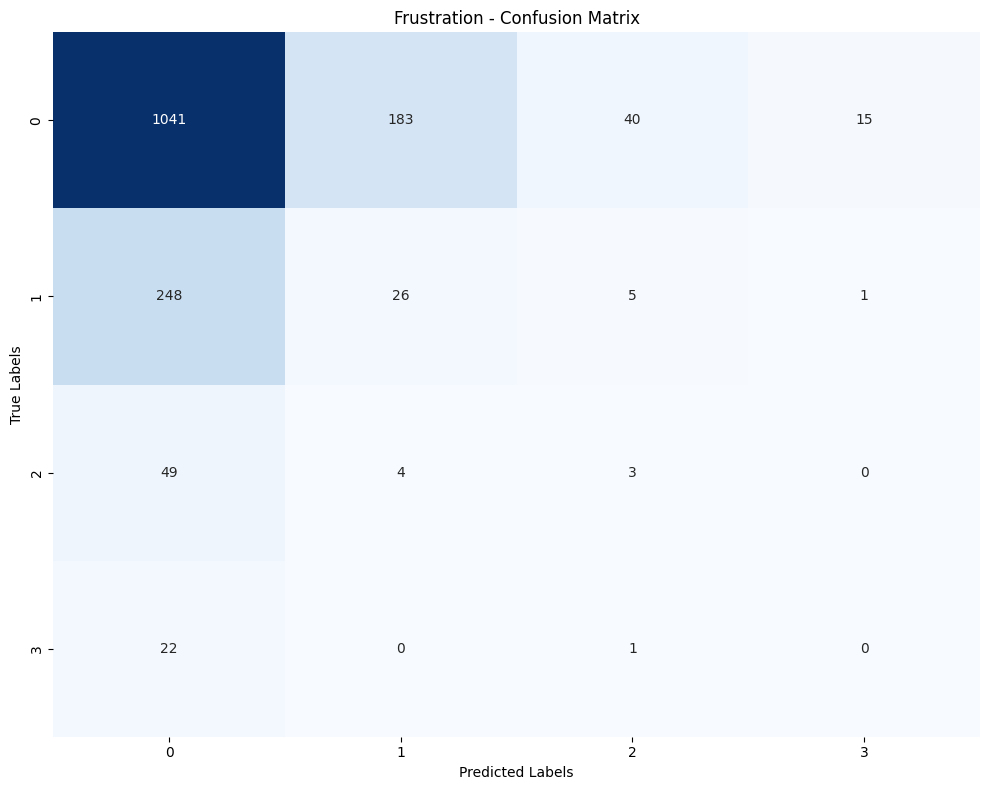

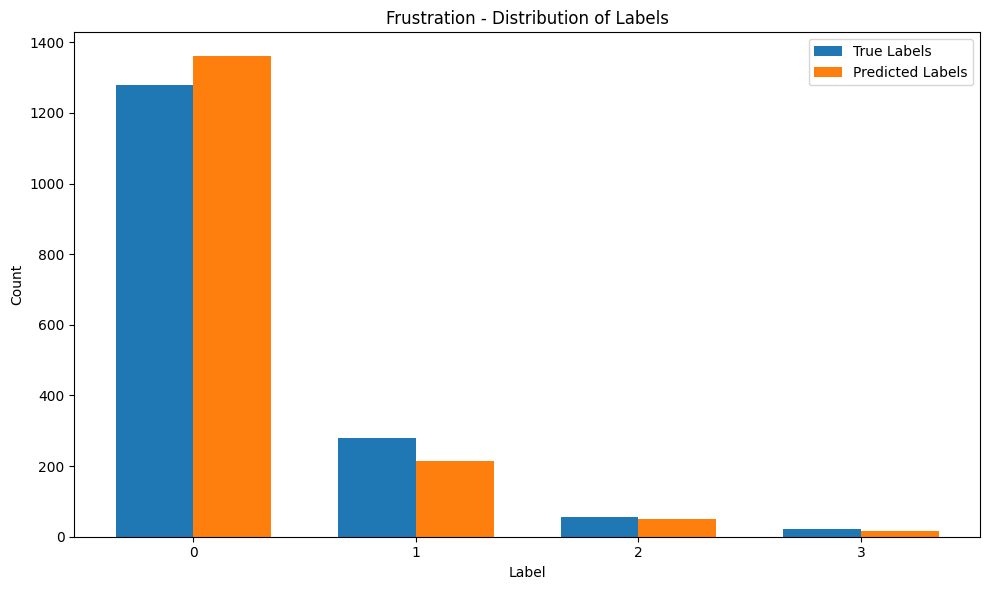

[Evaluation Complete]


In [9]:
# ------------------------------
# MAIN
# ------------------------------
if __name__ == "__main__":
    # torch.multiprocessing.set_start_method('spawn')

    train_csv = LABELS_DIR / "TrainLabels.csv"
    val_csv = LABELS_DIR / "ValidationLabels.csv"
    test_csv = LABELS_DIR / "TestLabels.csv"

    # Precompute flow-based frames + LMDB
    for csv_path in [train_csv, val_csv, test_csv]:
        for res in [112, 224, 300]:
            precompute_best_frames(csv_path, FRAMES_DIR, num_frames=NUM_FRAMES, resolution=res)
            convert_pkl_to_lmdb(csv_path, num_frames=NUM_FRAMES, resolution=res,
                                transform=get_transform(res))

    # Compute class weights for Weighted Loss
    weights_dict = compute_class_weights_for_daisee(train_csv, val_csv)

    # Hyperparam Tuning with Progressive + WeightedOrdinalCE
    def objective(trial):
        torch.cuda.empty_cache()
        gc.collect()

        batch_size = trial.suggest_categorical("batch_size", [4, 8])
        lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
        lstm_hidden = trial.suggest_categorical("lstm_hidden", [256, 512])
        lstm_layers = trial.suggest_categorical("lstm_layers", [1, 2])
        dropout_rate = trial.suggest_categorical("dropout_rate", [0.4, 0.5])
        drop_path_rate = trial.suggest_float("drop_path", 0.05, 0.15, step=0.05)  # e.g. 0.05, 0.1, 0.15
        total_epochs = sum(e for _, e in PROG_SCHEDULE)

        model = EfficientNetV2L_BiLSTM_CrossAttn_CBAM(
            lstm_hidden=lstm_hidden,
            lstm_layers=lstm_layers,
            dropout_rate=dropout_rate,
            classifier_hidden=256,
            drop_path_rate=drop_path_rate
        ).to(device)

        trial_ckpt = MODEL_DIR / f"trial_{trial.number}_ema.pth"
        loss_val = progressive_train_model(
            model, total_epochs, lr, trial_ckpt, batch_size,
            patience=EARLYSTOP_PATIENCE,
            gradient_accum_steps=GRADIENT_ACCUM_STEPS,
            weights_dict=weights_dict
        )
        del model
        torch.cuda.empty_cache()
        gc.collect()
        return loss_val

    db_path = BASE_DIR / "notebooks" / "tuning_effv2l_bilstm_flow_ema.db"
    db_path.parent.mkdir(parents=True, exist_ok=True)
    try:
        conn = sqlite3.connect(db_path)
        print(f"[DB] Connected => {db_path}")
        conn.close()
    except Exception as e:
        print(f"[DB Error] {e}")

    study = optuna.create_study(
        direction="minimize",
        pruner=MedianPruner(n_startup_trials=2, n_warmup_steps=10),
        study_name="flow_study_effv2l_ema",
        storage=f"sqlite:///{db_path}",
        load_if_exists=True
    )
    target_trials = 30
    while True:
        successes = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and np.isfinite(t.value)]
        remaining = target_trials - len(successes)
        if remaining <= 0:
            break
        print(f"Running {remaining} more trials to reach {target_trials} total.")
        study.optimize(objective, n_trials=remaining, catch=(Exception,))

    best_trial = min(successes, key=lambda t: t.value)
    print(f"[Best Trial] {best_trial.params}")

    # Final training on raw images with the best hyperparams
    total_epochs = sum(e for _, e in PROG_SCHEDULE)
    final_ckpt = MODEL_DIR / "final_ema_flow_effv2l.pth"
    if not final_ckpt.exists():
        print("[Final Training] Using raw images + best HP + WeightedLoss + EMA.")
        params = best_trial.params
        batch_size = params.get("batch_size", 4)
        lr = params.get("lr", 1e-4)
        lstm_hidden = params.get("lstm_hidden", 256)
        lstm_layers = params.get("lstm_layers", 1)
        dropout_rate = params.get("dropout_rate", 0.5)
        drop_path_rate = params.get("drop_path", 0.1)

        final_model = EfficientNetV2L_BiLSTM_CrossAttn_CBAM(
            lstm_hidden=lstm_hidden,
            lstm_layers=lstm_layers,
            dropout_rate=dropout_rate,
            classifier_hidden=256,
            drop_path_rate=drop_path_rate
        ).to(device)

        # Unfreeze from block=6 onward
        if hasattr(final_model.backbone, "blocks"):
            for i, block in enumerate(final_model.backbone.blocks):
                if i >= 6:
                    for param in block.parameters():
                        param.requires_grad = True

        # Train
        loss_val = progressive_train_model(
            final_model, total_epochs, lr, final_ckpt, batch_size,
            patience=EARLYSTOP_PATIENCE,
            gradient_accum_steps=GRADIENT_ACCUM_STEPS,
            weights_dict=weights_dict
        )
        print("[Final Training Complete].")
    else:
        print("[Final Checkpoint Found] Skipping retrain...")

    # Evaluate on test
    test_transform = get_transform(300)
    test_set = VideoDatasetRaw(test_csv, FRAMES_DIR, num_frames=NUM_FRAMES, transform=test_transform)
    # batch_size = best_trial.params.get("batch_size", 4)
    batch_size = 4 # use smaller batch for TTA

    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False,
                             num_workers=0, pin_memory=True)

    # Load final EMA weights
    eval_model = EfficientNetV2L_BiLSTM_CrossAttn_CBAM(
        lstm_hidden=best_trial.params.get("lstm_hidden", 256),
        lstm_layers=best_trial.params.get("lstm_layers", 1),
        dropout_rate=best_trial.params.get("dropout_rate", 0.5),
        classifier_hidden=256,
        drop_path_rate=best_trial.params.get("drop_path", 0.1)
    ).to(device)

    state = torch.load(final_ckpt, map_location=device)
    eval_model.load_state_dict(state["model_state_dict"])
    eval_model.to(device)

    evaluate_model(eval_model, test_loader)
    print("[Evaluation Complete]")
